# Random Forest

In [264]:
%pwd
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from scipy import interp

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import scale, label_binarize

from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from mpl_toolkits.mplot3d import Axes3D
import umap
import umap.plot
import trimap
import plotly.graph_objs as go
import plotly.express as px

import csv
from scipy import stats
from scipy.optimize import curve_fit

#Random Number
r = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"


In [265]:
def heatmap(mat, lbl=None):
    #Heatmap
    plt.figure(figsize = (12,10))
    ax = sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.yticks(rotation=0) 
    plt.title('Random Forest Classification Results', fontsize=18)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    
    ax.hlines([6, 16], color='k', *ax.get_xlim())
    ax.vlines([6, 16], color='k', *ax.get_xlim())
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=mat.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=mat.shape[0], color='k',linewidth=4)
    ax.tick_params(axis='both', which='both', length=0)
    
    plt.text(0.05, 0.77, 'CD4', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
    plt.text(0.325, 0.315, 'Treg', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
    plt.text(0.775, 0.04, 'CD8', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
    

## Load Data

In [266]:
#Loading in data
X = pd.read_csv('Data/Cells/All/tc.matrix_scaled_full.csv', index_col=0, sep=' ').T
y = pd.read_csv('Data/Cells/All/tc.clusters.csv', index_col=0, header=0, squeeze = True)


In [267]:
cd4 = pd.read_csv('Data/Cells/CD4/cd4.clusters.csv', index_col=0, header=0, squeeze = True)
cd8 = pd.read_csv('Data/Cells/CD8/cd8.clusters.csv', index_col=0, header=0, squeeze = True)
treg = pd.read_csv('Data/Cells/Treg/treg.clusters.csv', index_col=0, header=0, squeeze = True)
celltype = pd.read_csv('Data/Cells/All/tc.celltype.csv', index_col=0, header=0, squeeze = True)

In [268]:
genes = pd.read_csv('Data/Cells/All/genetic_signatures.csv', index_col=0, header=0, squeeze = True)
genes = list(genes['gene'].unique())

In [269]:
y.update(cd4)
y.update(cd8)
y.update(treg)

labels = y.unique()

In [270]:
celltype

AAACCTGAGAATAGGG-1    Treg
AAACCTGAGTTGTAGA-1    Treg
AAACCTGCACCAGATT-1    Treg
AAACCTGCACGGTAAG-1    Treg
AAACCTGCATGGTCTA-1     CD8
                      ... 
TTTGTCAGTAGCGCTC-1     CD4
TTTGTCAGTGTCTGAT-1     CD4
TTTGTCAGTGTGCGTC-1    Treg
TTTGTCAGTTATCACG-1     CD8
TTTGTCATCACAACGT-1     CD4
Name: x, Length: 6994, dtype: object

In [271]:
celldict = pd.Series(list(celltype), index=y).to_dict()
celldict

{'Treg-C7-Npm1': 'Treg',
 'Treg-C2-Il1rn': 'Treg',
 'Treg-C1-Klf2': 'Treg',
 'CD8-C4-Gzmc': 'CD8',
 'CD8-C1-Ccl4': 'CD8',
 'Treg-C6-AY036118': 'Treg',
 'ThEx': 'CD4',
 'Treg-C3-Ccl5': 'Treg',
 'CD8-C3-Dusp1': 'CD8',
 'Treg-C9-Stmn1': 'Treg',
 'ThCyto': 'CD4',
 'Th1': 'CD4',
 'Treg-C5-Nkg7': 'Treg',
 'CD8-C2-Id3': 'CD8',
 'ThEa': 'CD4',
 'ThNaive': 'CD4',
 'Treg-C4-Ptprc': 'Treg',
 'CD8-C5-Gzma': 'CD8',
 'Treg-C8-Isg15': 'Treg',
 'Treg-C10-Ccl8': 'Treg',
 'Th17': 'CD4',
 'CD8-C6-Ccr7': 'CD8'}

In [272]:
X = X[X.columns & genes]
X

,Rpl7,Eloc,Il17a,Mcm3,Ptpn18,Neurl3,Cox5b,Mitd1,Mrpl30,Rpl31,...,Usmg5,Dusp5,Ablim1,mt-Nd1,mt-Nd2,mt-Atp6,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Cytb
AAACCTGAGAATAGGG-1,0.714522,0.210211,-0.092054,3.156752,0.637649,-0.402931,0.836611,1.301681,-0.696370,0.643052,...,0.903684,-0.712680,-0.789130,-0.483788,-0.593030,-0.305428,-0.482833,0.231603,0.153425,0.164354
AAACCTGAGTTGTAGA-1,0.058329,1.124451,-0.092054,-0.243671,-2.029888,-0.402931,0.864891,-0.338620,1.249401,-1.388146,...,-1.106721,-0.712680,-0.789130,0.334074,0.098479,-0.677767,-0.193688,0.041712,-1.058234,0.101464
AAACCTGCACCAGATT-1,-0.002026,-0.758671,-0.092054,-0.243671,0.428890,-0.402931,0.811890,-0.338620,-0.696370,-1.388146,...,-1.106721,1.863800,1.427591,-0.231106,-1.325868,-0.752986,-1.585698,-1.420799,-1.058234,-0.840791
AAACCTGCACGGTAAG-1,0.164939,1.509446,-0.092054,-0.243671,-0.130364,-0.402931,-1.259591,3.501266,-0.696370,1.363242,...,-1.106721,-0.712680,1.215922,0.652973,-1.325868,-0.190728,-1.585698,-1.420799,-1.058234,0.449362
AAACCTGCATGGTCTA-1,0.376558,0.143181,-0.092054,-0.243671,0.005364,0.726443,0.595484,1.188200,0.755844,0.409403,...,1.335524,-0.712680,0.763713,0.634573,0.206856,0.696293,0.880221,0.590406,1.044855,1.140956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTAGCGCTC-1,0.677318,-0.758671,-0.092054,-0.243671,0.316030,-0.402931,1.054409,-0.338620,-0.696370,-1.388146,...,1.289238,-0.712680,1.687115,-1.613882,-1.325868,0.171626,-1.585698,0.754677,-1.058234,1.174168
TTTGTCAGTGTCTGAT-1,0.092073,1.156857,-0.092054,-0.243671,1.159055,-0.402931,0.322817,2.904338,1.282886,-1.388146,...,1.763007,1.955100,-0.789130,-0.162958,-1.325868,-0.412313,0.341908,0.066880,-1.058234,-0.214679
TTTGTCAGTGTGCGTC-1,-0.787908,-0.758671,-0.092054,-0.243671,0.561627,-0.402931,-1.259591,3.661425,-0.696370,-1.388146,...,-1.106721,1.360795,1.299551,0.175768,0.461235,-1.191142,-1.585698,-1.420799,-1.058234,0.532813
TTTGTCAGTTATCACG-1,-0.121940,-0.758671,-0.092054,-0.243671,-0.223409,-0.402931,0.522309,-0.338620,-0.696370,1.104292,...,0.738292,-0.712680,0.552175,0.744593,1.309596,0.865063,0.863726,0.254431,0.173989,0.807272


In [273]:
y

AAACCTGAGAATAGGG-1        Treg-C7-Npm1
AAACCTGAGTTGTAGA-1       Treg-C2-Il1rn
AAACCTGCACCAGATT-1       Treg-C2-Il1rn
AAACCTGCACGGTAAG-1        Treg-C1-Klf2
AAACCTGCATGGTCTA-1         CD8-C4-Gzmc
                            ...       
TTTGTCAGTAGCGCTC-1                ThEx
TTTGTCAGTGTCTGAT-1                 Th1
TTTGTCAGTGTGCGTC-1    Treg-C6-AY036118
TTTGTCAGTTATCACG-1          CD8-C2-Id3
TTTGTCATCACAACGT-1                ThEx
Name: x, Length: 6994, dtype: object

In [274]:
feature_list = list(X.columns)
print(y.value_counts())

Th1                 655
Treg-C1-Klf2        610
Treg-C2-Il1rn       575
Treg-C3-Ccl5        548
ThEa                548
ThNaive             548
Treg-C4-Ptprc       443
ThEx                431
Treg-C5-Nkg7        409
Treg-C6-AY036118    341
CD8-C1-Ccl4         299
Treg-C7-Npm1        290
CD8-C2-Id3          257
CD8-C3-Dusp1        225
CD8-C4-Gzmc         206
Treg-C8-Isg15       195
Treg-C9-Stmn1       172
CD8-C5-Gzma          92
ThCyto               81
Th17                 34
Treg-C10-Ccl8        20
CD8-C6-Ccr7          15
Name: x, dtype: int64


In [275]:
labels = ["ThNaive", "ThEa", "Th1", "Th17", "ThCyto", "ThEx",
          "Treg-C1-Klf2", "Treg-C2-Il1rn", "Treg-C3-Ccl5", "Treg-C4-Ptprc", "Treg-C5-Nkg7", "Treg-C6-AY036118", "Treg-C7-Npm1", "Treg-C8-Isg15", "Treg-C9-Stmn1", "Treg-C10-Ccl8", 
          "CD8-C1-Ccl4", "CD8-C2-Id3", "CD8-C3-Dusp1", "CD8-C4-Gzmc", "CD8-C5-Gzma", "CD8-C6-Ccr7"]

## Pearson Correlation

In [276]:
gcn = X.corr('pearson')

C:\Users\andre\Anaconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



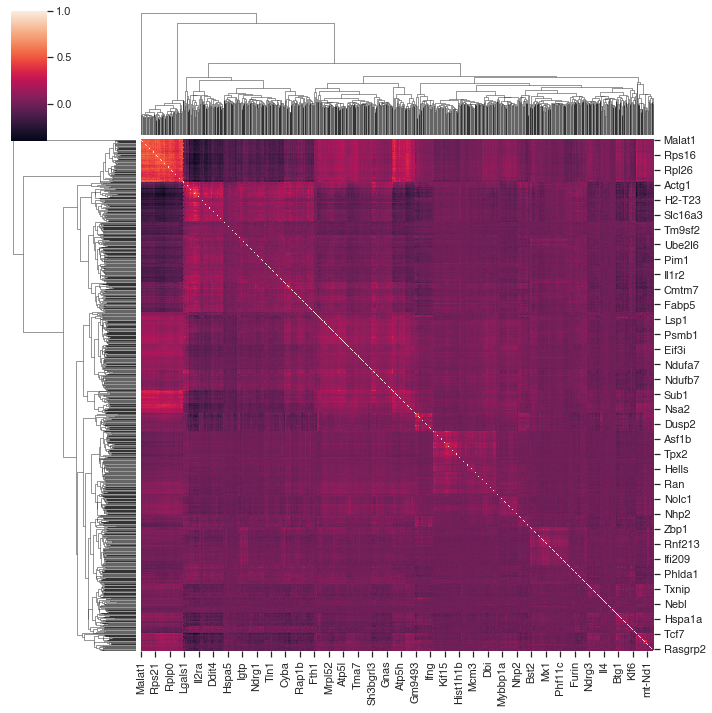

In [277]:
sns.clustermap(gcn)

In [278]:
gcn

,Rpl7,Eloc,Il17a,Mcm3,Ptpn18,Neurl3,Cox5b,Mitd1,Mrpl30,Rpl31,...,Usmg5,Dusp5,Ablim1,mt-Nd1,mt-Nd2,mt-Atp6,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Cytb
Rpl7,1.000000,0.096818,-0.017390,0.018224,0.242248,0.011578,0.150959,0.043023,0.137968,0.288086,...,0.153803,-0.071220,0.032945,0.133147,0.163142,0.091779,0.162013,0.135631,0.122957,0.132370
Eloc,0.096818,1.000000,0.035934,0.046434,0.074700,-0.030372,0.099086,0.038598,0.071005,0.078827,...,0.091138,-0.008005,-0.026469,-0.015420,-0.007536,-0.022998,0.002421,0.000570,0.024091,0.006112
Il17a,-0.017390,0.035934,1.000000,0.000673,-0.012951,-0.025666,0.001935,0.001182,-0.011256,0.006392,...,0.030122,0.034416,-0.018117,-0.006112,-0.021975,-0.019430,-0.009342,-0.010040,-0.001777,-0.012335
Mcm3,0.018224,0.046434,0.000673,1.000000,-0.006670,-0.014464,0.048883,0.005405,0.030761,0.023235,...,0.044217,-0.013357,-0.019140,0.043035,0.041542,0.031788,0.039174,0.026091,0.015156,0.025217
Ptpn18,0.242248,0.074700,-0.012951,-0.006670,1.000000,-0.009626,0.122957,0.045251,0.081334,0.114725,...,0.127137,0.019508,-0.040311,-0.035882,0.004181,-0.082869,-0.004025,-0.012394,0.010949,-0.020732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Atp6,0.091779,-0.022998,-0.019430,0.031788,-0.082869,0.003563,-0.002104,0.022629,0.000887,0.113166,...,-0.040968,-0.088583,0.087433,0.375079,0.341331,1.000000,0.403250,0.343216,0.292889,0.431233
mt-Nd4l,0.162013,0.002421,-0.009342,0.039174,-0.004025,0.008275,0.065179,0.012386,0.039660,0.141595,...,0.014118,-0.073194,0.063442,0.338848,0.343892,0.403250,1.000000,0.302540,0.263210,0.393688
mt-Nd4,0.135631,0.000570,-0.010040,0.026091,-0.012394,-0.018916,0.062814,0.012275,0.025100,0.133277,...,-0.017163,-0.050857,0.064319,0.270809,0.278135,0.343216,0.302540,1.000000,0.220041,0.310007
mt-Nd5,0.122957,0.024091,-0.001777,0.015156,0.010949,-0.006675,0.053928,0.019838,0.045675,0.112268,...,0.012130,-0.045359,0.056565,0.222562,0.234642,0.292889,0.263210,0.220041,1.000000,0.277766


## PCA

In [279]:
#PCA
pca = PCA()
dfpc = pca.fit_transform(X)

[0.06661276 0.03887315 0.01711662 0.01284543 0.01050124 0.00857218
 0.0072625  0.0062339  0.00575168 0.00476145 0.0045411  0.00374956
 0.00356304 0.00345848 0.0032677  0.00310565 0.0027998  0.00270521
 0.00259348 0.00251826 0.00243821 0.00240225 0.00234595 0.00229695
 0.00223601 0.00221958 0.00214584 0.00208992 0.00200309 0.00193274
 0.00192806 0.00191844 0.00189836 0.00188372 0.00185957 0.00182803
 0.00180782 0.00179411 0.00177057 0.00176568 0.00174908 0.00174252
 0.00172835 0.00171831 0.00171565 0.00170105 0.00169632 0.00169303
 0.00168782 0.00168337 0.00167748 0.00166412 0.00166361 0.00166087
 0.00165075 0.00164608 0.0016449  0.00163746 0.00163301 0.00163145
 0.00162675 0.00162342 0.00161566 0.0016147  0.0016106  0.00160256
 0.0015997  0.00159294 0.00159147 0.00158927 0.00158278 0.00158066
 0.00157494 0.00157422 0.00157045 0.00156847 0.00156604 0.00155716
 0.00155172 0.00154986 0.00154819 0.00154498 0.00153906 0.00153195
 0.00153064 0.0015295  0.00152755 0.00152554 0.0015244  0.0015

 0.00028265 0.00027643 0.00026896 0.00026663 0.00025809 0.00025285]


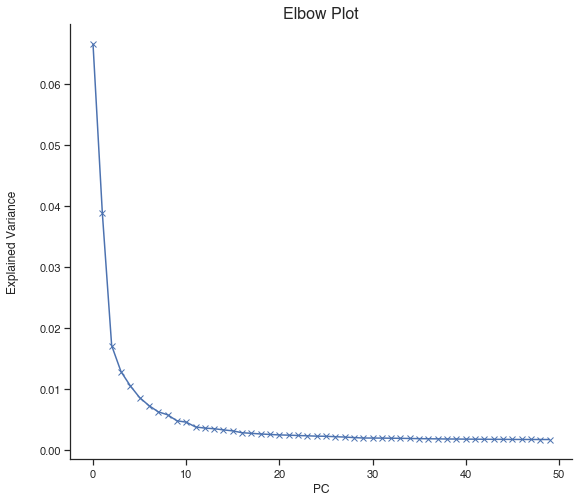

In [280]:
#Scree Plot
print(pca.explained_variance_ratio_)
plt.figure(figsize = (9,8))
plt.plot(pca.explained_variance_ratio_[:50], 'bx-') 
plt.xlabel('PC') 
plt.ylabel('Explained Variance', labelpad=20) 
plt.title('Elbow Plot', fontsize=16)
sns.despine()
plt.show()

Text(0.5, 1.02, 'PCA')

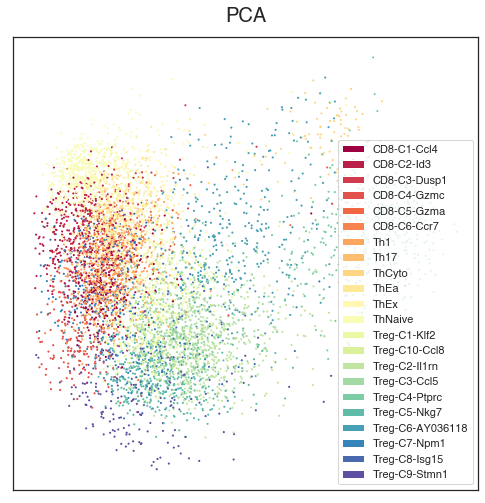

In [281]:
ax = umap.plot._matplotlib_points(dfpc[:,:2], labels=y, width=600, height=600)
ax.set(xticks=[], yticks=[])
ax.set_title('PCA', fontsize = 20, y=1.02)

Text(0.5, 1.02, 'PCA')

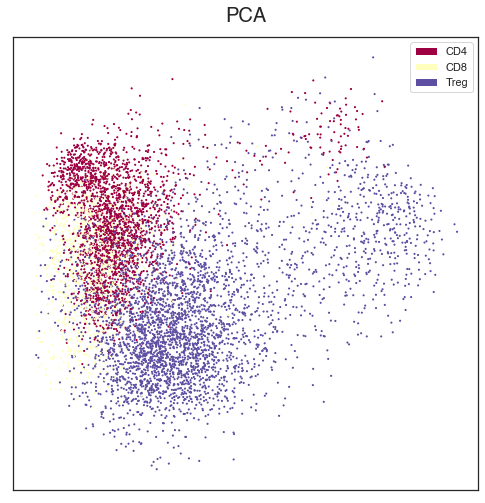

In [282]:
ax = umap.plot._matplotlib_points(dfpc[:,:2], labels=celltype, width=600, height=600)
ax.set(xticks=[], yticks=[])
ax.set_title('PCA', fontsize = 20, y=1.02)

## SMOTE Oversampling

In [283]:
#X = X_orig
#y = y_orig

In [284]:
X_orig = X
y_orig = y

In [285]:
cellcount = dict(y_orig.value_counts())
for i in cellcount:
    if cellcount[i] < 80:
        cellcount[i] = 80
cellcount

{'Th1': 655,
 'Treg-C1-Klf2': 610,
 'Treg-C2-Il1rn': 575,
 'Treg-C3-Ccl5': 548,
 'ThEa': 548,
 'ThNaive': 548,
 'Treg-C4-Ptprc': 443,
 'ThEx': 431,
 'Treg-C5-Nkg7': 409,
 'Treg-C6-AY036118': 341,
 'CD8-C1-Ccl4': 299,
 'Treg-C7-Npm1': 290,
 'CD8-C2-Id3': 257,
 'CD8-C3-Dusp1': 225,
 'CD8-C4-Gzmc': 206,
 'Treg-C8-Isg15': 195,
 'Treg-C9-Stmn1': 172,
 'CD8-C5-Gzma': 92,
 'ThCyto': 81,
 'Th17': 80,
 'Treg-C10-Ccl8': 80,
 'CD8-C6-Ccr7': 80}

In [286]:
#Variables and Acutal
feature_list = list(X_orig.columns)
print(y_orig.value_counts())

#Oversampling
#X, y = SMOTETomek(random_state=r, sampling_strategy=cellcount, n_jobs=-1).fit_resample(X_orig, y_orig)
print(y.value_counts())

Th1                 655
Treg-C1-Klf2        610
Treg-C2-Il1rn       575
Treg-C3-Ccl5        548
ThEa                548
ThNaive             548
Treg-C4-Ptprc       443
ThEx                431
Treg-C5-Nkg7        409
Treg-C6-AY036118    341
CD8-C1-Ccl4         299
Treg-C7-Npm1        290
CD8-C2-Id3          257
CD8-C3-Dusp1        225
CD8-C4-Gzmc         206
Treg-C8-Isg15       195
Treg-C9-Stmn1       172
CD8-C5-Gzma          92
ThCyto               81
Th17                 34
Treg-C10-Ccl8        20
CD8-C6-Ccr7          15
Name: x, dtype: int64
Th1                 655
Treg-C1-Klf2        610
Treg-C2-Il1rn       575
Treg-C3-Ccl5        548
ThEa                548
ThNaive             548
Treg-C4-Ptprc       443
ThEx                431
Treg-C5-Nkg7        409
Treg-C6-AY036118    341
CD8-C1-Ccl4         299
Treg-C7-Npm1        290
CD8-C2-Id3          257
CD8-C3-Dusp1        225
CD8-C4-Gzmc         206
Treg-C8-Isg15       195
Treg-C9-Stmn1       172
CD8-C5-Gzma          92
ThCyto            

In [287]:
#PCA
pca = PCA()
dfpc = pca.fit_transform(X)

[0.06661276 0.03887315 0.01711662 0.01284543 0.01050124 0.00857218
 0.0072625  0.0062339  0.00575168 0.00476145 0.0045411  0.00374956
 0.00356304 0.00345848 0.0032677  0.00310565 0.0027998  0.00270521
 0.00259348 0.00251826 0.00243821 0.00240225 0.00234595 0.00229695
 0.00223601 0.00221958 0.00214584 0.00208992 0.00200309 0.00193274
 0.00192806 0.00191844 0.00189836 0.00188372 0.00185957 0.00182803
 0.00180782 0.00179411 0.00177057 0.00176568 0.00174908 0.00174252
 0.00172835 0.00171831 0.00171565 0.00170105 0.00169632 0.00169303
 0.00168782 0.00168337 0.00167748 0.00166412 0.00166361 0.00166087
 0.00165075 0.00164608 0.0016449  0.00163746 0.00163301 0.00163145
 0.00162675 0.00162342 0.00161566 0.0016147  0.0016106  0.00160256
 0.0015997  0.00159294 0.00159147 0.00158927 0.00158278 0.00158066
 0.00157494 0.00157422 0.00157045 0.00156847 0.00156604 0.00155716
 0.00155172 0.00154986 0.00154819 0.00154498 0.00153906 0.00153195
 0.00153064 0.0015295  0.00152755 0.00152554 0.0015244  0.0015

 0.00028265 0.00027643 0.00026896 0.00026663 0.00025809 0.00025285]


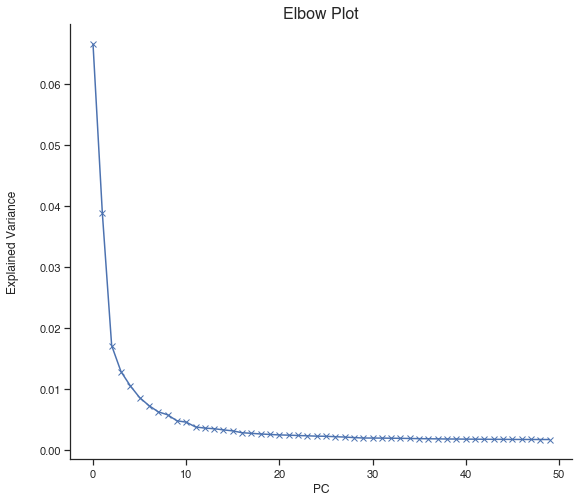

In [288]:
#Scree Plot
print(pca.explained_variance_ratio_)
plt.figure(figsize = (9,8))
plt.plot(pca.explained_variance_ratio_[:50], 'bx-') 
plt.xlabel('PC') 
plt.ylabel('Explained Variance', labelpad=20) 
plt.title('Elbow Plot', fontsize=16)
sns.despine()
plt.show()

Text(0.5, 1.02, 'PCA')

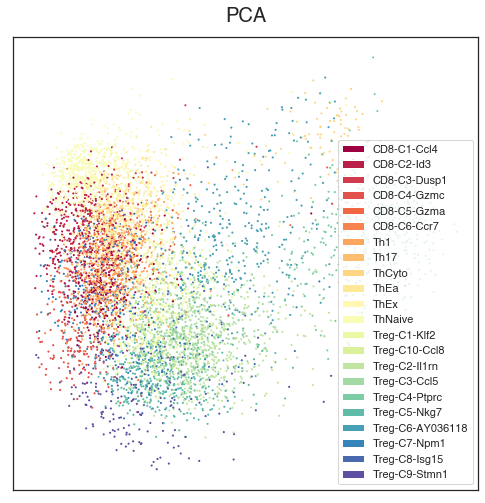

In [289]:
ax = umap.plot._matplotlib_points(dfpc[:,:2], labels=y, width=600, height=600)
ax.set(xticks=[], yticks=[])
ax.set_title('PCA', fontsize = 20, y=1.02)

## Train/Test Split

In [290]:
y = pd.Series(y)

#Count
print(y.value_counts())

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

Th1                 655
Treg-C1-Klf2        610
Treg-C2-Il1rn       575
Treg-C3-Ccl5        548
ThEa                548
ThNaive             548
Treg-C4-Ptprc       443
ThEx                431
Treg-C5-Nkg7        409
Treg-C6-AY036118    341
CD8-C1-Ccl4         299
Treg-C7-Npm1        290
CD8-C2-Id3          257
CD8-C3-Dusp1        225
CD8-C4-Gzmc         206
Treg-C8-Isg15       195
Treg-C9-Stmn1       172
CD8-C5-Gzma          92
ThCyto               81
Th17                 34
Treg-C10-Ccl8        20
CD8-C6-Ccr7          15
Name: x, dtype: int64
Training Features Shape: (5595, 888)
Training Labels Shape: (5595,)
Testing Features Shape: (1399, 888)
Testing Labels Shape: (1399,)
Th1                 510
Treg-C1-Klf2        477
Treg-C2-Il1rn       475
Treg-C3-Ccl5        440
ThNaive             431
ThEa                430
Treg-C4-Ptprc       360
ThEx                353
Treg-C5-Nkg7        330
Treg-C6-AY036118    270
Treg-C7-Npm1        241
CD8-C1-Ccl4         237
CD8-C2-Id3          208
CD8-

## Outer Random Forest

In [291]:
#Outer Random Forest
rf = RandomForestClassifier(n_estimators = 1000, random_state=r, oob_score=True, verbose=1, n_jobs = -1, class_weight="balanced")
rf.fit(X_train, y_train) #Train
y_pred = rf.predict(X_test) #Predict

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [292]:
labels

['ThNaive',
 'ThEa',
 'Th1',
 'Th17',
 'ThCyto',
 'ThEx',
 'Treg-C1-Klf2',
 'Treg-C2-Il1rn',
 'Treg-C3-Ccl5',
 'Treg-C4-Ptprc',
 'Treg-C5-Nkg7',
 'Treg-C6-AY036118',
 'Treg-C7-Npm1',
 'Treg-C8-Isg15',
 'Treg-C9-Stmn1',
 'Treg-C10-Ccl8',
 'CD8-C1-Ccl4',
 'CD8-C2-Id3',
 'CD8-C3-Dusp1',
 'CD8-C4-Gzmc',
 'CD8-C5-Gzma',
 'CD8-C6-Ccr7']

Results: 


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                  precision    recall  f1-score   support

     CD8-C1-Ccl4       0.67      0.85      0.75        62
      CD8-C2-Id3       0.77      0.90      0.83        49
    CD8-C3-Dusp1       0.93      0.68      0.78        40
     CD8-C4-Gzmc       0.88      0.70      0.78        40
     CD8-C5-Gzma       0.89      0.42      0.57        19
             Th1       0.64      0.82      0.72       145
            Th17       0.00      0.00      0.00        13
          ThCyto       0.88      0.58      0.70        12
            ThEa       0.67      0.72      0.69       118
            ThEx       0.82      0.47      0.60        78
         ThNaive       0.88      0.97      0.93       117
    Treg-C1-Klf2       0.74      0.77      0.76       133
   Treg-C10-Ccl8       0.00      0.00      0.00         4
   Treg-C2-Il1rn       0.56      0.79      0.66       100
    Treg-C3-Ccl5       0.66      0.61      0.63       108
   Treg-C4-Ptprc       0.73      0.99      0.84        83
    Treg-C5-N

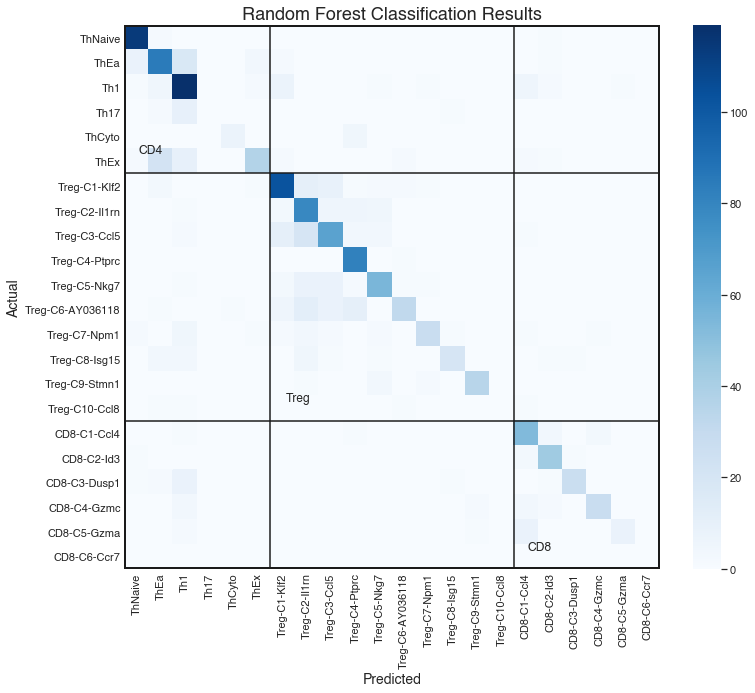

In [293]:
#Results
print("Results: ")
mat = confusion_matrix(y_test, y_pred, labels=labels)
print(classification_report(y_test,y_pred)) #Accuarcy
print('Test: ', accuracy_score(y_test, y_pred))
print('OOB Score: ', rf.oob_score_)
#Heatmap
heatmap(mat)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



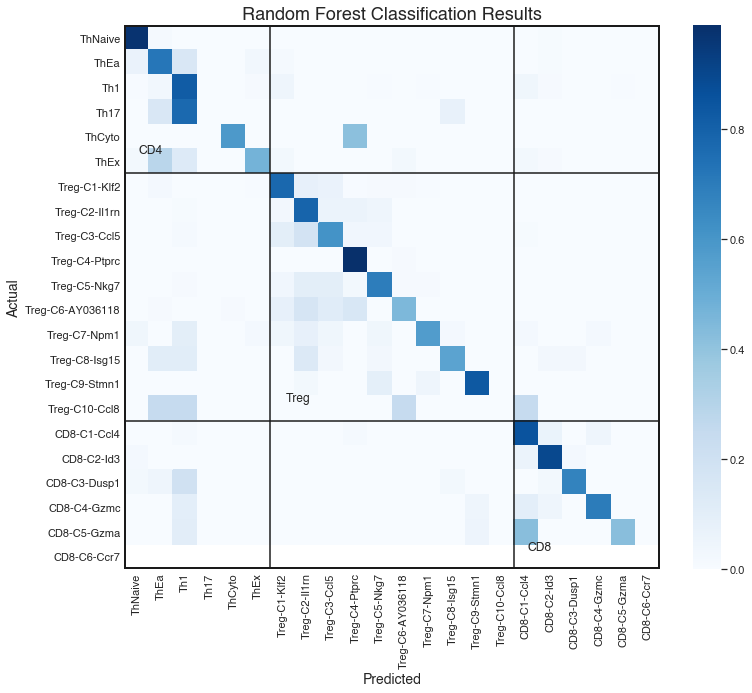

In [294]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
#Heatmap
heatmap(mat)

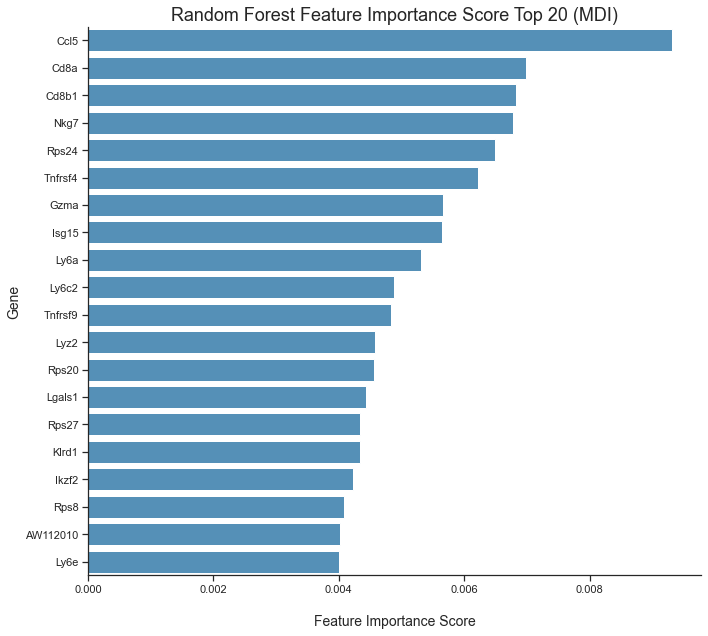

In [295]:
#Feature Importance
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

#Barplot
plt.figure(figsize = (10,9))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20], color = '#4594c7')
sns.despine()
plt.title('Random Forest Feature Importance Score Top 20 (MDI)', fontsize=18)
plt.xlabel('Feature Importance Score', fontsize=14,labelpad=20)
plt.ylabel('Gene', fontsize=14)
plt.tight_layout()
#plt.savefig('Graphs/outer_bar.pdf', format='pdf', transparent=True)

Ccl5     0.009312
Cd8a     0.016303
Cd8b1    0.023131
Nkg7     0.029910
Rps24    0.036397
           ...   
Fbxo5    0.999592
Cenpm    0.999705
Knl1     0.999816
Ccnb1    0.999926
Aspm     1.000000
Length: 888, dtype: float64


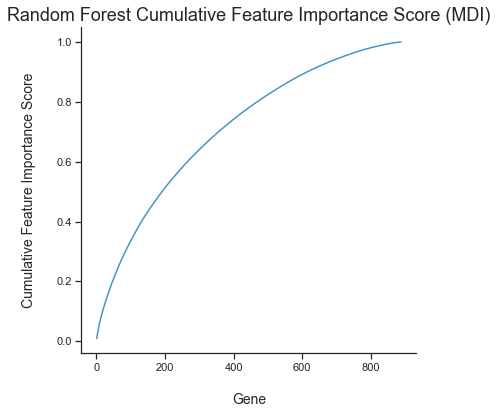

In [296]:
feature_imp_cum = feature_imp.cumsum()
print(feature_imp_cum)
plt.figure(figsize = (6,6))
sns.set(font_scale=1)
sns.set_style("ticks")
plt.plot(range(1, feature_imp_cum.size+1), feature_imp_cum, color = '#4594c7')
sns.despine()
plt.title('Random Forest Cumulative Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Gene', fontsize=14,labelpad=20)
plt.ylabel('Cumulative Feature Importance Score', fontsize=14,labelpad=20)
#plt.savefig('Graphs/outer_cumulative_feature_importance.pdf', format='pdf', transparent=True)
plt.show()

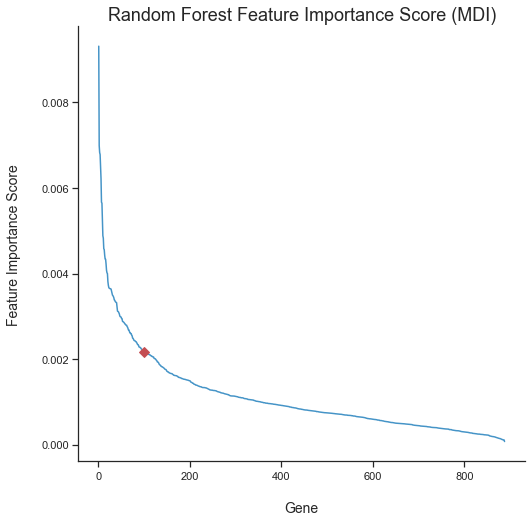

In [297]:
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.set_style("ticks")
plt.plot(range(1, feature_imp.size+1), feature_imp, '-D', markevery=[100], color = '#4594c7', markerfacecolor="r", markeredgecolor="r", markersize=7)
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Gene', fontsize=14,labelpad=20)
plt.ylabel('Feature Importance Score', fontsize=14,labelpad=20)
#plt.savefig('Graphs/outer_feature_importance.pdf', format='pdf', transparent=True)
plt.show()

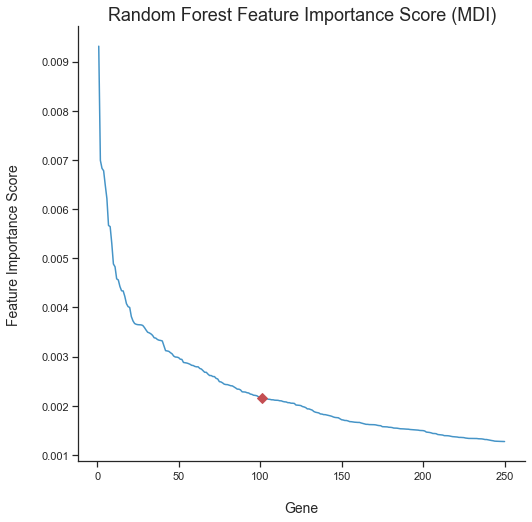

In [263]:
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.set_style("ticks")
plt.plot(range(1, feature_imp[:250].size+1), feature_imp[:250], '-D', markevery=[100], color = '#4594c7', markerfacecolor="r", markeredgecolor="r", markersize=7)
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Gene', fontsize=14,labelpad=20)
plt.ylabel('Feature Importance Score', fontsize=14,labelpad=20)
#plt.savefig('Graphs/outer_feature_importance_2000.pdf', format='pdf', transparent=True)
plt.show()

## Save Top 250 Features

In [150]:
#Save genes
#feature_imp[:250].to_csv('Output/250_feature_importance_scores.txt', quoting=csv.QUOTE_MINIMAL)
#feature_imp[:250].index.to_series().to_csv('Output/250_ranked_genes.txt', quoting=csv.QUOTE_MINIMAL, index=False)

## Subset

In [151]:
#Top 50 Genes
n_genes=250
X_train_i = X_train.loc[:, feature_imp.index[:n_genes]]
X_test_i = X_test.loc[:, feature_imp.index[:n_genes]]
X_i = X.loc[:, feature_imp.index[:n_genes]]
indexes = feature_imp.index[:n_genes]

## Inner Random Forest

In [152]:
#Inner Random Forest
rf_most_important = RandomForestClassifier(n_estimators = 1000, random_state=r, oob_score=True, verbose=1, n_jobs = -1, class_weight="balanced_subsample")

rf_most_important.fit(X_train_i, y_train)
y_pred_train = rf_most_important.predict(X_train_i)
y_pred = rf_most_important.predict(X_test_i)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Results: 
                  precision    recall  f1-score   support

     CD8-C1-Ccl4       0.69      0.79      0.74        62
      CD8-C2-Id3       0.78      0.76      0.77        55
    CD8-C3-Dusp1       0.74      0.42      0.53        48
     CD8-C4-Gzmc       0.78      0.60      0.68        42
     CD8-C5-Gzma       0.85      0.85      0.85        40
     CD8-C6-Ccr7       0.97      1.00      0.99        38
             Th1       0.56      0.68      0.62       135
            Th17       0.95      1.00      0.98        41
          ThCyto       0.95      0.95      0.95        38
            ThEa       0.50      0.55      0.53       103
            ThEx       0.66      0.47      0.55        87
         ThNaive       0.84      0.93      0.88       102
    Treg-C1-Klf2       0.57      0.64      0.60       121
   Treg-C10-Ccl8       0.88      1.00      0.93        42
   Treg-C2-Il1rn       0.51      0.63      0.56       118
    Treg-C3-Ccl5       0.51      0.48      0.50       113
   

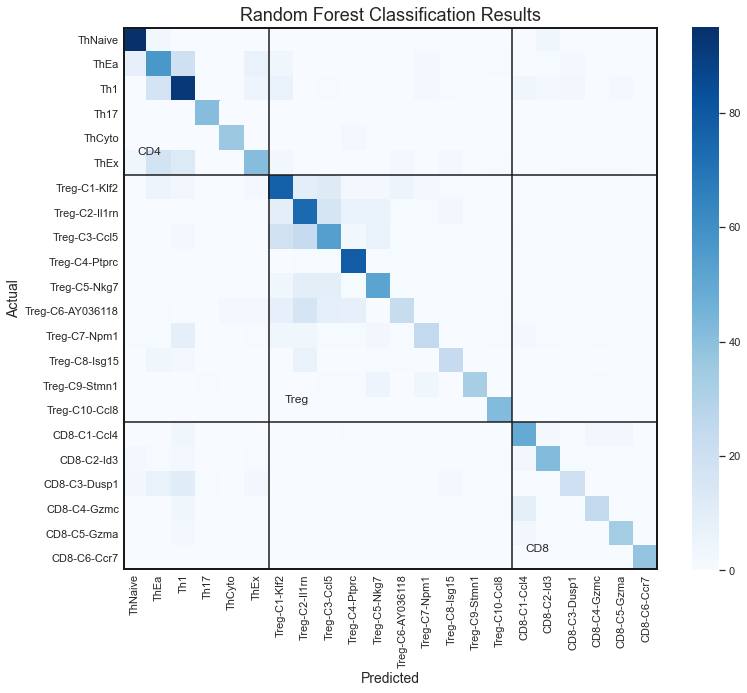

In [153]:
#Results
print("Results: ")
mat = confusion_matrix(y_test, y_pred, labels=labels)
print(classification_report(y_test,y_pred))
print('Train: ', accuracy_score(y_train, y_pred_train))
print('Test: ', accuracy_score(y_test, y_pred))
print('OOB Score: ', rf_most_important.oob_score_)

#Heatmap
heatmap(mat)

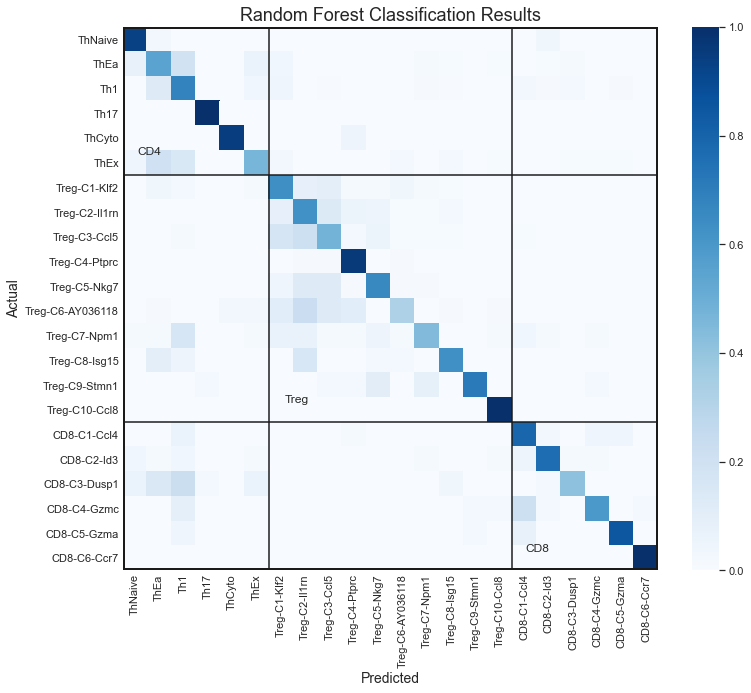

In [154]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
#Heatmap
heatmap(mat)

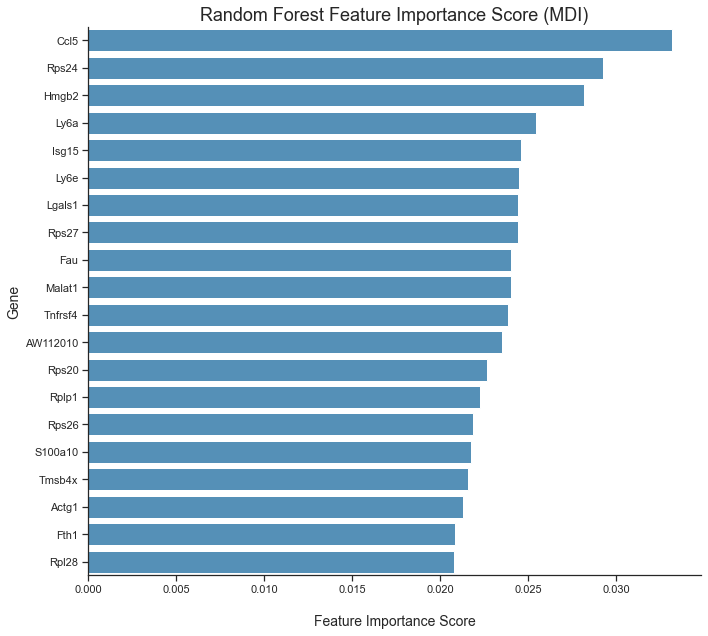

In [155]:
#Feature Importance
feature_imp = pd.Series(rf_most_important.feature_importances_,index=X_i.columns).sort_values(ascending=False)

#Barplot
plt.figure(figsize = (10,9))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20], color = '#4594c7')
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Feature Importance Score', fontsize=14,labelpad=20)
plt.ylabel('Gene', fontsize=14)
plt.tight_layout()
#plt.savefig('Graphs/inner_bar.pdf', format='pdf', transparent=True)

Ccl5        0.033167
Rps24       0.062385
Hmgb2       0.090570
Ly6a        0.116038
Isg15       0.140613
Ly6e        0.165065
Lgals1      0.189508
Rps27       0.213900
Fau         0.237927
Malat1      0.261947
Tnfrsf4     0.285806
AW112010    0.309290
Rps20       0.331949
Rplp1       0.354184
Rps26       0.376061
S100a10     0.397838
Tmsb4x      0.419427
Actg1       0.440712
Fth1        0.461536
Rpl28       0.482304
Rpl35a      0.503013
Rps3a1      0.523689
Rps8        0.544310
Nkg7        0.564925
Klf2        0.585464
Rplp0       0.605772
Ikzf2       0.626059
Tnfrsf9     0.646198
Tpt1        0.666292
Ifi27l2a    0.686307
Rpl32       0.706088
Rpl41       0.725651
Rpl38       0.745075
Rps16       0.764277
Rps15a      0.783427
Rpl13       0.801998
Rpl10a      0.820174
Cd8a        0.837734
Rps4x       0.855101
Cd8b1       0.871900
Lyz2        0.887743
Ccr7        0.903066
Aqp3        0.918280
Foxp3       0.933166
Ly6c2       0.945961
Tmem176a    0.958275
C1qb        0.969943
Klrd1       0

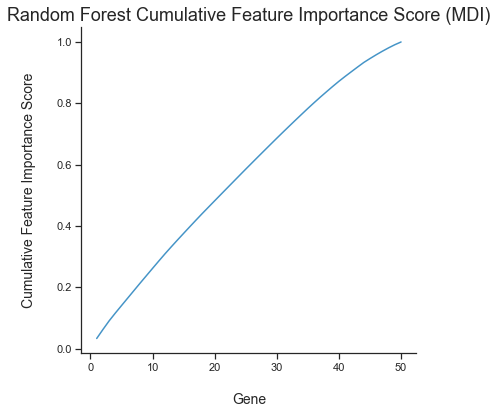

In [156]:
feature_imp_cum = feature_imp.cumsum()
print(feature_imp_cum)
plt.figure(figsize = (6,6))
sns.set(font_scale=1)
sns.set_style("ticks")
plt.plot(range(1, feature_imp_cum.size+1), feature_imp_cum, color = '#4594c7')
sns.despine()
plt.title('Random Forest Cumulative Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Gene', fontsize=14,labelpad=20)
plt.ylabel('Cumulative Feature Importance Score', fontsize=14,labelpad=20)
#plt.savefig('Graphs/inner_cumulative_feature_importance.pdf', format='pdf', transparent=True)
plt.show()

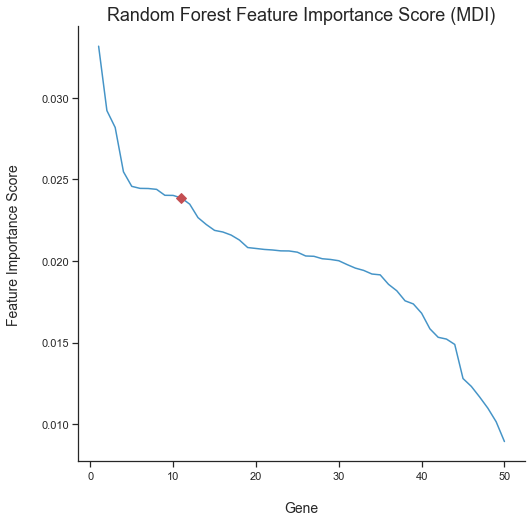

In [157]:
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.set_style("ticks")
plt.plot(range(1, feature_imp.size+1), feature_imp, "-D", markevery=[10], color = '#4594c7', markerfacecolor="r", markeredgecolor="r", markersize=7)
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Gene', fontsize=14,labelpad=20)
plt.ylabel('Feature Importance Score', fontsize=14,labelpad=20)
#plt.savefig('Graphs/inner_feature_importance.pdf', format='pdf', transparent=True)
plt.show()

## Save Top 50 Features

In [158]:
#Save genes
#feature_imp.to_csv('Output/50_feature_importance_scores.txt', quoting=csv.QUOTE_MINIMAL)
#feature_imp.index.to_series().to_csv('Output/50_ranked_genes.txt', quoting=csv.QUOTE_MINIMAL, index=False)

## Save Top 20 Features

In [159]:
#Save genes
#feature_imp[:20].to_csv('Output/20_feature_importance_scores.txt', quoting=csv.QUOTE_MINIMAL)
#feature_imp[:20].index.to_series().to_csv('Output/20_ranked_genes.txt', quoting=csv.QUOTE_MINIMAL, index=False)

## 5 Fold Cross Validation

In [160]:
#5 Fold Cross Validation
y_pred = cross_val_predict(rf_most_important, X_i, y, cv=5, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 311 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   13.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Usi

In [161]:
#5 Fold Cross Validation Probabilities
y_pred_prob = cross_val_predict(rf_most_important, X_i, y, cv=5, verbose=3, method='predict_proba')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 688 

Results: 
                  precision    recall  f1-score   support

     CD8-C1-Ccl4       0.68      0.81      0.74       299
      CD8-C2-Id3       0.75      0.78      0.76       257
    CD8-C3-Dusp1       0.74      0.45      0.56       225
     CD8-C4-Gzmc       0.73      0.66      0.69       206
     CD8-C5-Gzma       0.86      0.89      0.87       200
     CD8-C6-Ccr7       0.97      0.99      0.98       200
             Th1       0.58      0.70      0.64       655
            Th17       0.90      0.97      0.93       200
          ThCyto       0.88      0.91      0.90       200
            ThEa       0.56      0.57      0.56       548
            ThEx       0.62      0.45      0.52       431
         ThNaive       0.82      0.90      0.86       548
    Treg-C1-Klf2       0.56      0.64      0.60       610
   Treg-C10-Ccl8       0.93      0.99      0.96       200
   Treg-C2-Il1rn       0.52      0.63      0.57       575
    Treg-C3-Ccl5       0.56      0.52      0.54       548
   

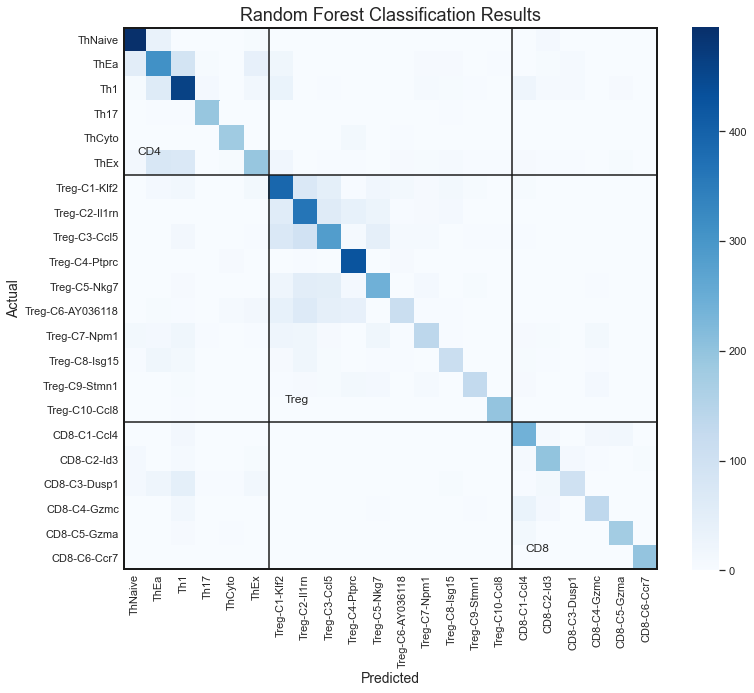

In [162]:
#Results
print("Results: ")
mat = confusion_matrix(y, y_pred, labels=labels)
print(classification_report(y,y_pred))
print('Accuracy: ', accuracy_score(y, y_pred))
print('OOB Score: ', rf_most_important.oob_score_)

#Heatmap
heatmap(mat)

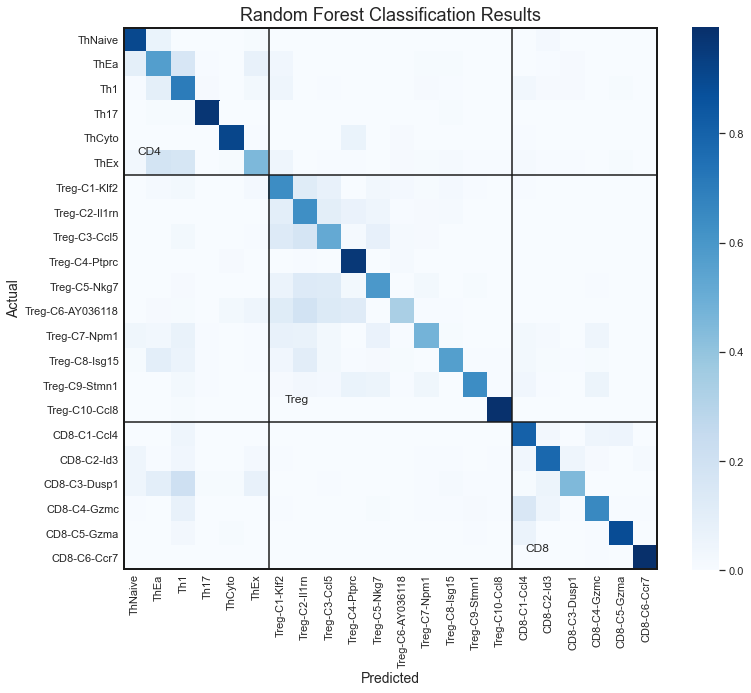

In [163]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
#Heatmap
heatmap(mat)

In [164]:
# Save
y_pred_prob = pd.DataFrame(y_pred_prob, columns=rf_most_important.classes_)
#y_pred_prob.to_csv('Output/Random Forest Probabilities.txt', quoting=csv.QUOTE_MINIMAL)
y_pred_prob

,CD8-C1-Ccl4,CD8-C2-Id3,CD8-C3-Dusp1,CD8-C4-Gzmc,CD8-C5-Gzma,CD8-C6-Ccr7,Th1,Th17,ThCyto,ThEa,...,Treg-C1-Klf2,Treg-C10-Ccl8,Treg-C2-Il1rn,Treg-C3-Ccl5,Treg-C4-Ptprc,Treg-C5-Nkg7,Treg-C6-AY036118,Treg-C7-Npm1,Treg-C8-Isg15,Treg-C9-Stmn1
0,0.002,0.002,0.011,0.022,0.003,0.000,0.072,0.002,0.000,0.009,...,0.047,0.001,0.025,0.040,0.000,0.433,0.006,0.171,0.009,0.129
1,0.003,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.001,...,0.122,0.000,0.433,0.201,0.003,0.098,0.062,0.029,0.029,0.007
2,0.009,0.001,0.000,0.002,0.000,0.000,0.041,0.000,0.003,0.014,...,0.105,0.034,0.256,0.218,0.025,0.136,0.068,0.026,0.020,0.018
3,0.002,0.003,0.022,0.007,0.003,0.000,0.093,0.001,0.009,0.090,...,0.242,0.001,0.059,0.205,0.025,0.018,0.135,0.014,0.019,0.009
4,0.090,0.006,0.004,0.560,0.003,0.001,0.020,0.003,0.000,0.001,...,0.011,0.000,0.000,0.003,0.000,0.004,0.000,0.012,0.009,0.271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778,0.103,0.024,0.010,0.190,0.012,0.018,0.033,0.001,0.000,0.007,...,0.020,0.000,0.004,0.013,0.000,0.021,0.000,0.009,0.008,0.519
7779,0.007,0.000,0.000,0.008,0.000,0.001,0.016,0.000,0.000,0.001,...,0.020,0.000,0.010,0.018,0.000,0.227,0.000,0.017,0.005,0.669
7780,0.002,0.000,0.000,0.007,0.000,0.001,0.022,0.006,0.000,0.005,...,0.096,0.000,0.042,0.049,0.000,0.391,0.002,0.094,0.002,0.272
7781,0.001,0.007,0.005,0.036,0.001,0.002,0.029,0.005,0.000,0.010,...,0.068,0.000,0.023,0.042,0.000,0.210,0.001,0.060,0.003,0.488


## Per Class Importances

Results: 
                  precision    recall  f1-score   support

     CD8-C1-Ccl4       0.68      0.81      0.74       299
      CD8-C2-Id3       0.75      0.78      0.76       257
    CD8-C3-Dusp1       0.74      0.45      0.56       225
     CD8-C4-Gzmc       0.73      0.66      0.69       206
     CD8-C5-Gzma       0.86      0.89      0.87       200
     CD8-C6-Ccr7       0.97      0.99      0.98       200
             Th1       0.58      0.70      0.64       655
            Th17       0.90      0.97      0.93       200
          ThCyto       0.88      0.91      0.90       200
            ThEa       0.56      0.57      0.56       548
            ThEx       0.62      0.45      0.52       431
         ThNaive       0.82      0.90      0.86       548
    Treg-C1-Klf2       0.56      0.64      0.60       610
   Treg-C10-Ccl8       0.93      0.99      0.96       200
   Treg-C2-Il1rn       0.52      0.63      0.57       575
    Treg-C3-Ccl5       0.56      0.52      0.54       548
   

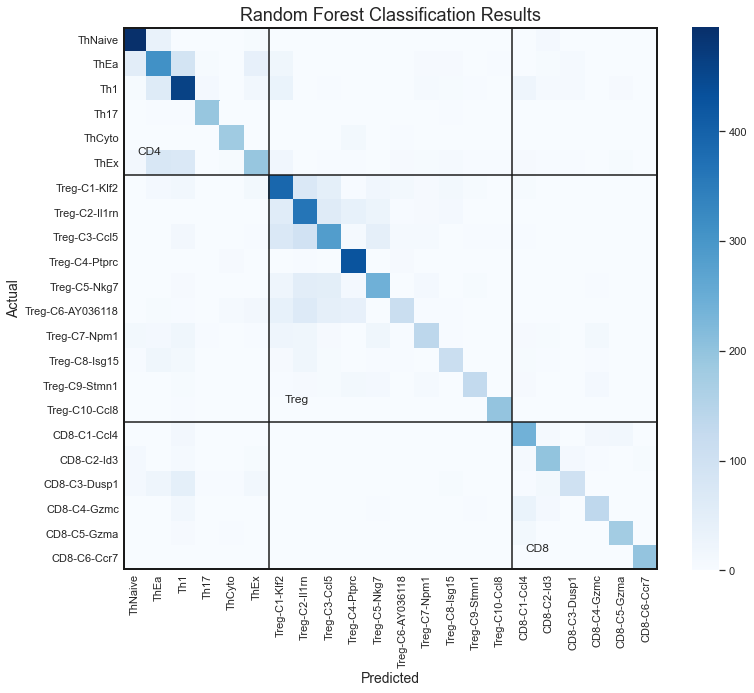

In [165]:
#Results
print("Results: ")
mat = confusion_matrix(y, y_pred, labels=labels)
print(classification_report(y,y_pred))
print('Accuracy: ', accuracy_score(y, y_pred))
print('OOB Score: ', rf_most_important.oob_score_)

#Heatmap
heatmap(mat)

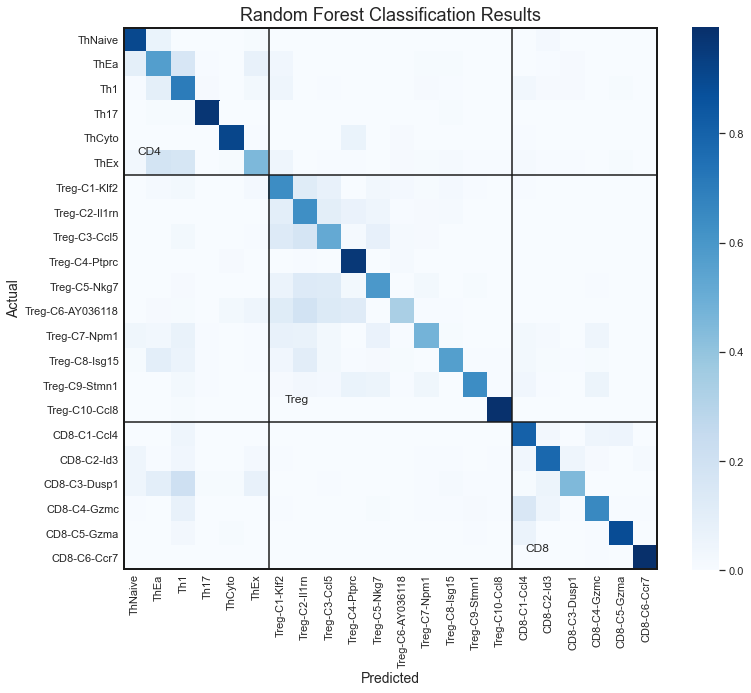

In [166]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
#Heatmap
heatmap(mat)

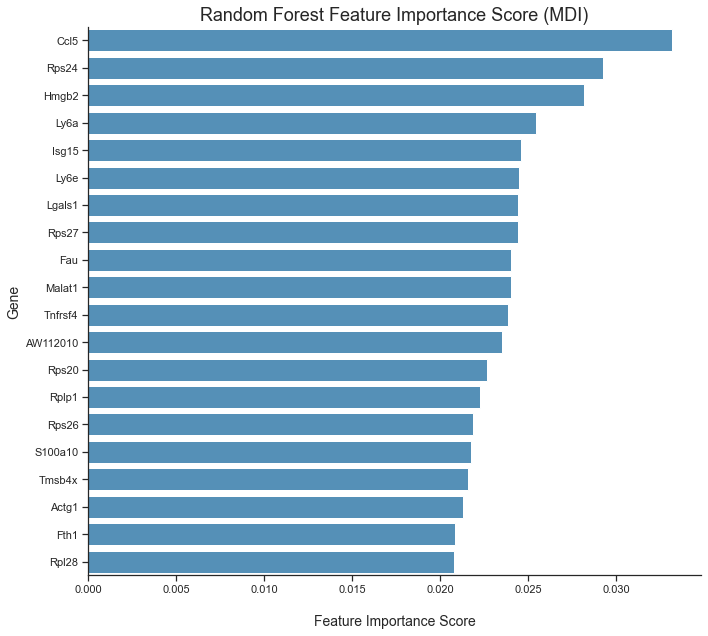

In [167]:
#Feature Importance
feature_imp = pd.Series(rf_most_important.feature_importances_,index=X_i.columns).sort_values(ascending=False)

#Barplot
plt.figure(figsize = (10,9))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20], color = '#4594c7')
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=18)
plt.xlabel('Feature Importance Score', fontsize=14,labelpad=20)
plt.ylabel('Gene', fontsize=14)
plt.tight_layout()
#plt.savefig('Graphs/inner_bar.pdf', format='pdf', transparent=True)

In [168]:
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)
    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(feature_imp.index, np.mean(X[Y==c, :], axis=0)*feature_importances)
        )
    return out

In [169]:
class_feature_imp = class_feature_importance(X_i, y, feature_imp)
class_feature_imp

{'Treg-C9-Stmn1': {'Ccl5': -0.001811365732146172,
  'Rps24': 0.004302248122034509,
  'Hmgb2': 0.003743855509772534,
  'Ly6a': -0.005445642095673903,
  'Isg15': 0.0019835824488760884,
  'Ly6e': 0.008610029468451623,
  'Lgals1': -0.0035276415108890357,
  'Rps27': -0.0009343402703191229,
  'Fau': 0.00937980861157215,
  'Malat1': 0.005348499045312394,
  'Tnfrsf4': -0.0033658833075304677,
  'AW112010': 0.00821806300442028,
  'Rps20': -0.0010990973647668277,
  'Rplp1': 0.006920348775724327,
  'Rps26': -0.0019827893851703648,
  'S100a10': -0.003266186003063456,
  'Tmsb4x': -0.011919394465227747,
  'Actg1': 0.0053774358048571565,
  'Fth1': 0.006322422385872428,
  'Rpl28': -0.00244459226711932,
  'Rpl35a': 0.0010986891406070262,
  'Rps3a1': -0.017930465718848022,
  'Rps8': -0.0014608150378964625,
  'Nkg7': 0.004604374823220961,
  'Klf2': -0.0023110358541905264,
  'Rplp0': 0.015416425795019348,
  'Ikzf2': 0.00890162402693028,
  'Tnfrsf9': -0.0014186382929339742,
  'Tpt1': 0.0020139895317322284,


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



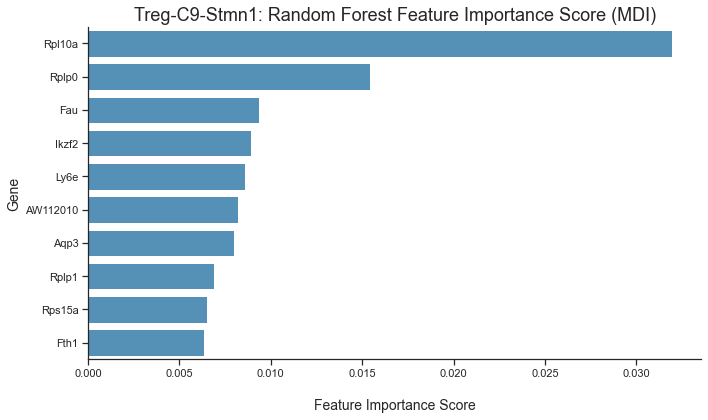

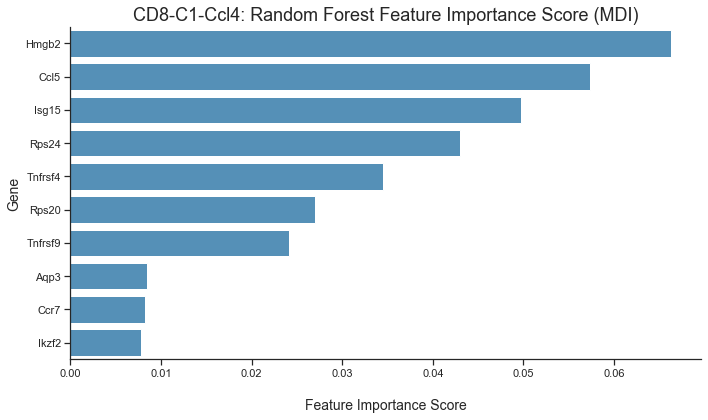

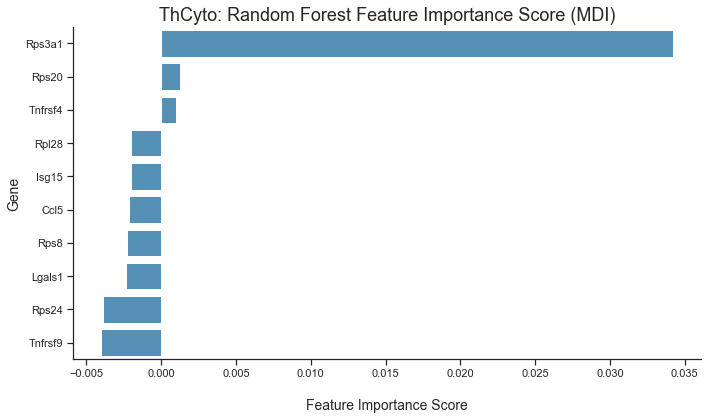

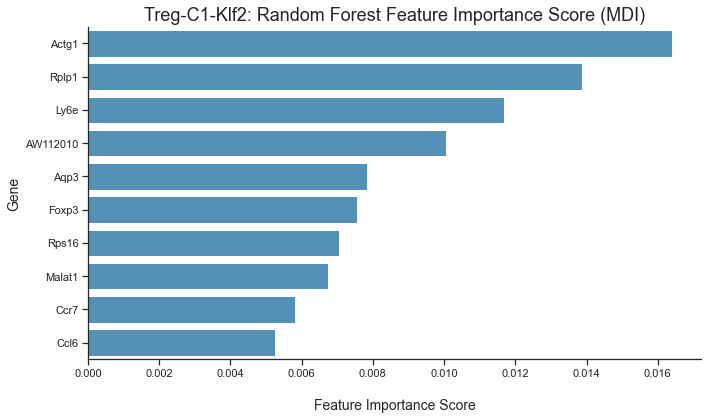

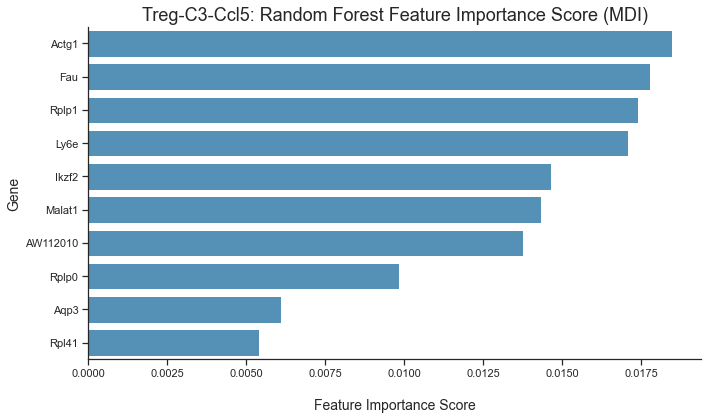

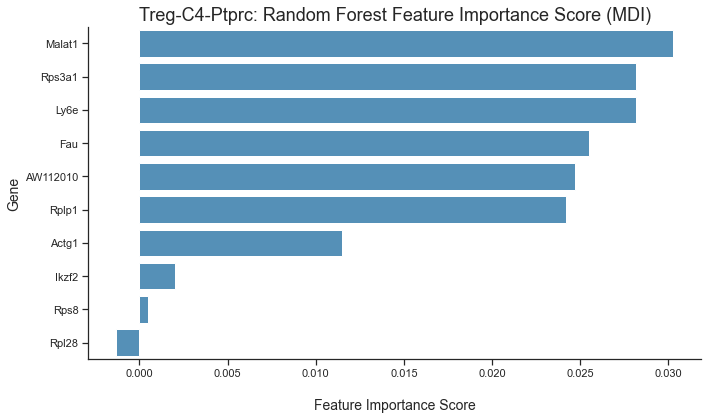

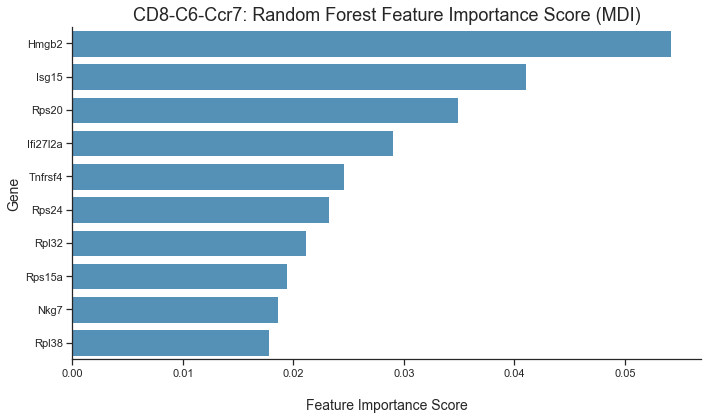

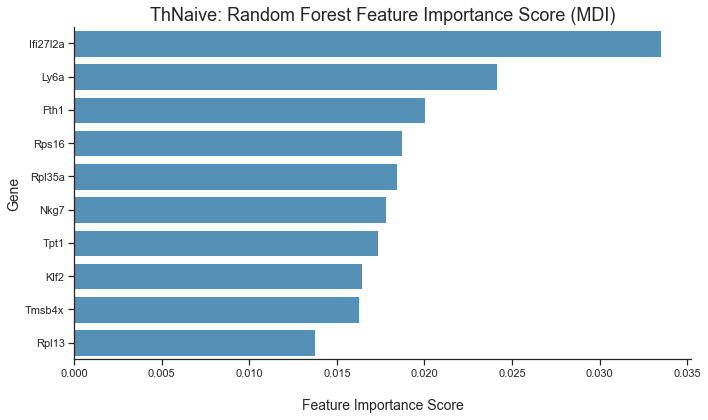

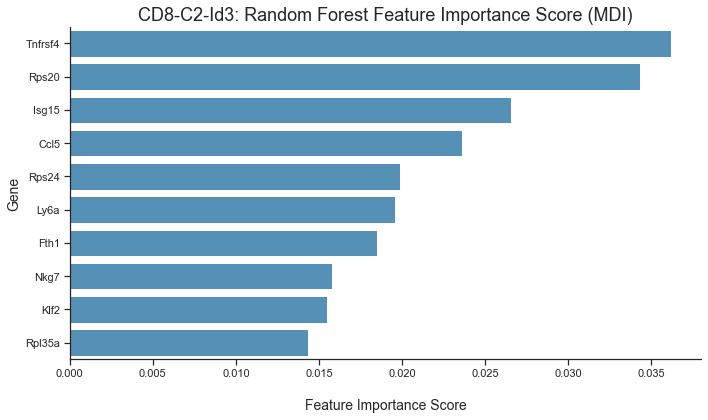

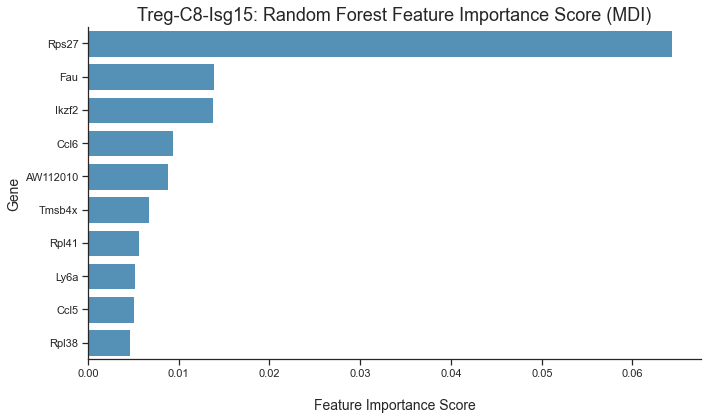

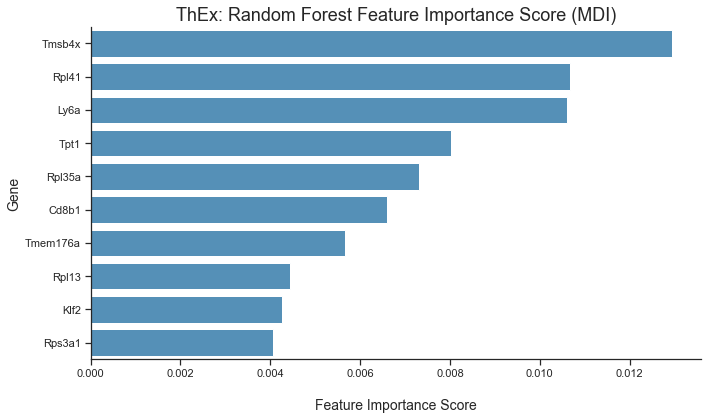

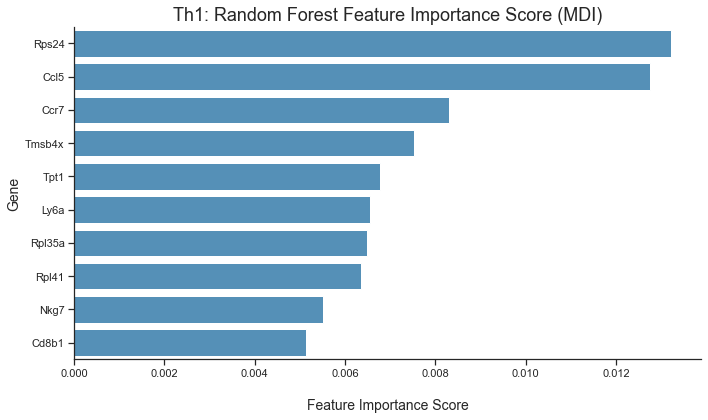

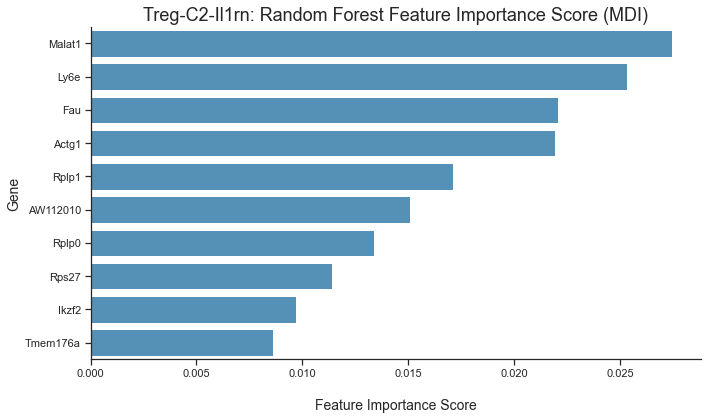

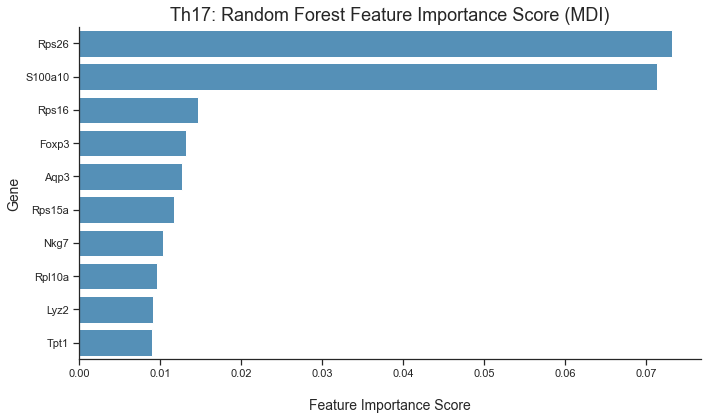

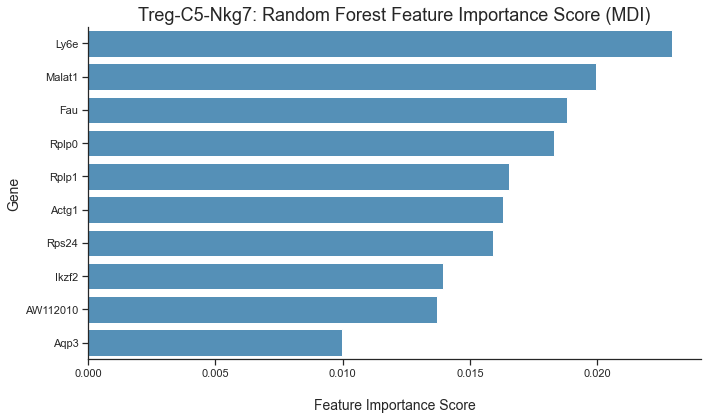

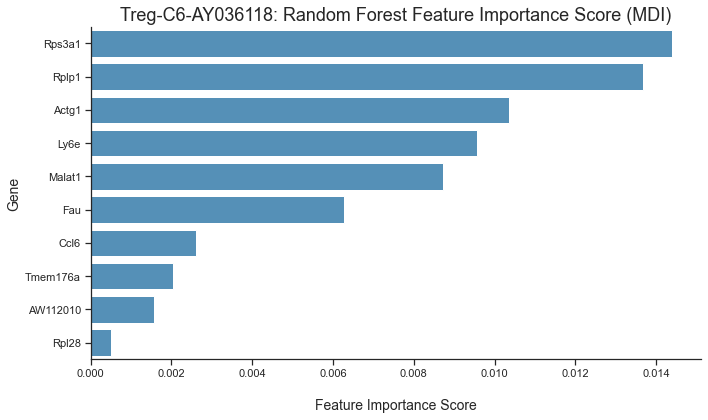

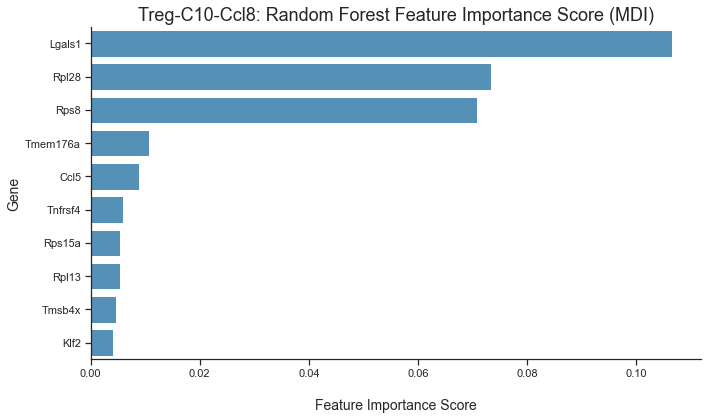

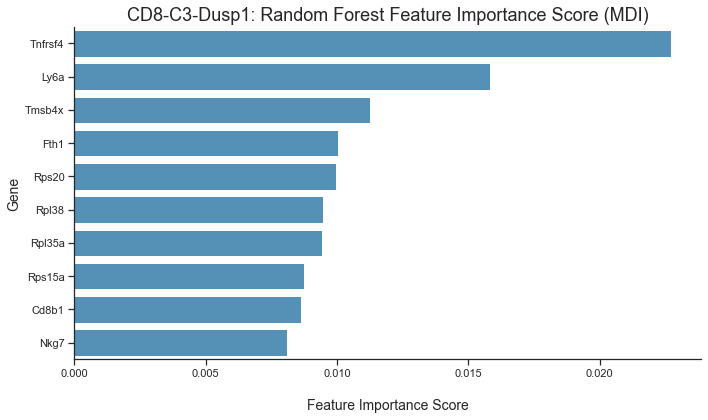

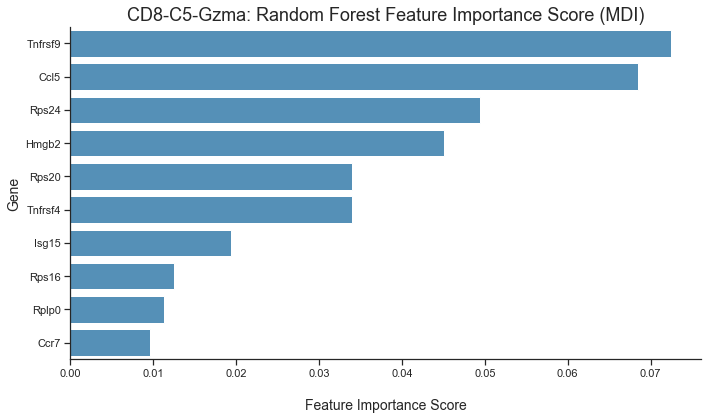

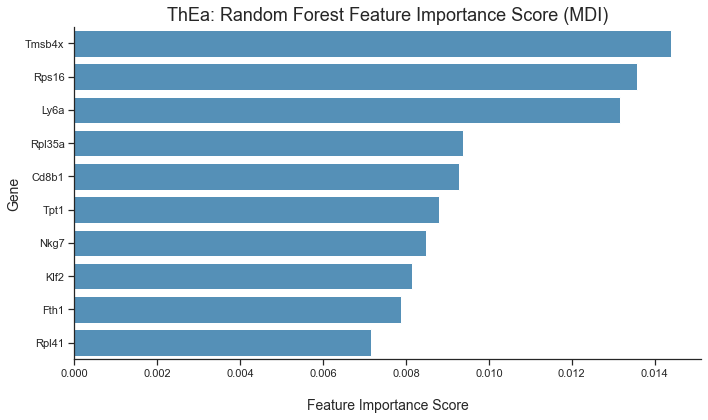

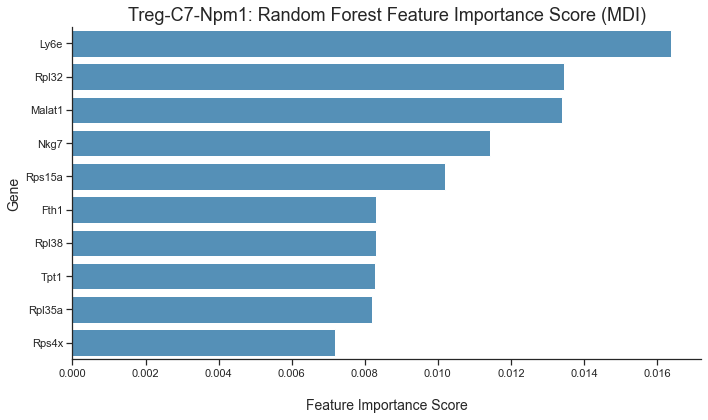

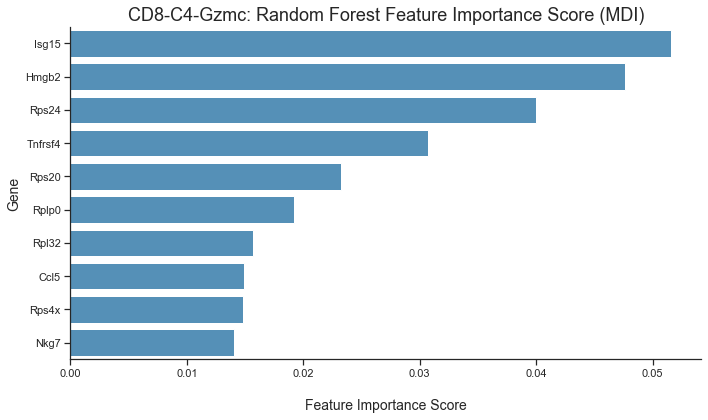

In [170]:
for i in class_feature_imp:
    #Feature Importance
    imp = pd.Series(class_feature_imp[i]).sort_values(ascending=False)
    #Barplot
    plt.figure(figsize = (10,6))
    sns.set(font_scale=1)
    sns.set_style("ticks")
    sns.barplot(x=imp[:10], y=imp.index[:10], color = '#4594c7')
    sns.despine()
    plt.title(i + ': Random Forest Feature Importance Score (MDI)', fontsize=18)
    plt.xlabel('Feature Importance Score', fontsize=14,labelpad=20)
    plt.ylabel('Gene', fontsize=14)
    plt.tight_layout()

In [171]:
#Binarize the output
y_test_bin = label_binarize(y_pred, classes=labels)
n_classes = y_test_bin.shape[1]

AUC for ThNaive: 0.9993225397161667
AUC for ThEa: 0.9887228992054924
AUC for Th1: 0.9899684482236573
AUC for Th17: 0.9999479954382822
AUC for ThCyto: 0.9997527007512514
AUC for ThEx: 0.993285438678476
AUC for Treg-C1-Klf2: 0.9881842747791117
AUC for Treg-C2-Il1rn: 0.9929942734278281
AUC for Treg-C3-Ccl5: 0.9819815274091009
AUC for Treg-C4-Ptprc: 0.9996213840513607
AUC for Treg-C5-Nkg7: 0.9967622190142298
AUC for Treg-C6-AY036118: 0.9922433589592727
AUC for Treg-C7-Npm1: 0.9982913902787192
AUC for Treg-C8-Isg15: 0.9994247455977006
AUC for Treg-C9-Stmn1: 0.99927718077943
AUC for Treg-C10-Ccl8: 0.999995658672422
AUC for CD8-C1-Ccl4: 0.9974062511469153
AUC for CD8-C2-Id3: 0.9989384963006158
AUC for CD8-C3-Dusp1: 0.9987259517380902
AUC for CD8-C4-Gzmc: 0.9993664762419697
AUC for CD8-C5-Gzma: 0.9995144706778369
AUC for CD8-C6-Ccr7: 0.9999948503047976


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



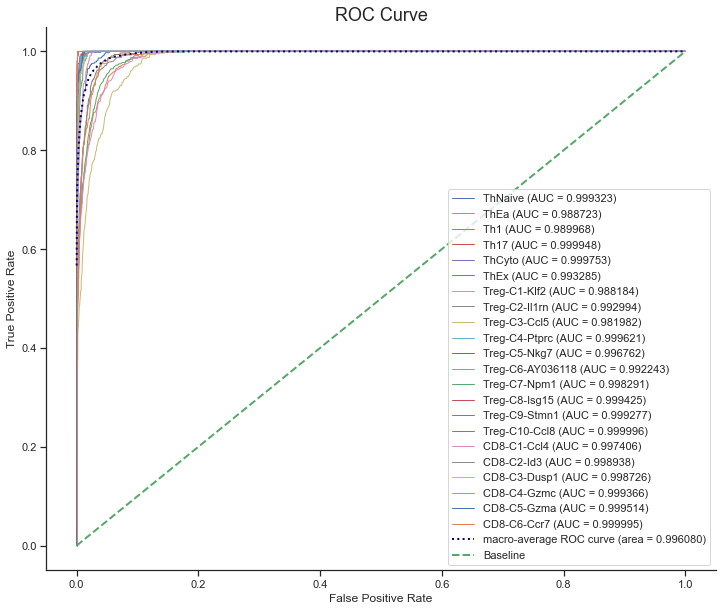

In [172]:
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize = (12, 10))

# Plot both curves
sns.set(font_scale=1)
sns.set_style("ticks")

for i in range(n_classes):
    roc_value = roc_auc_score(y_test_bin[:, i], y_pred_prob[labels].to_numpy()[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[labels].to_numpy()[:, i])
    plt.plot(fpr[i], tpr[i], lw=1, label = labels[i] + r' (AUC = %0.6f)' % (roc_value))
    print('AUC for {}: {}'.format(labels[i], auc(fpr[i], tpr[i])))

    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)


plt.plot([0, 1], [0, 1], label = 'Baseline', linestyle='--', lw=2)
sns.despine()
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=18)
#plt.savefig('Graphs/ROC_comparison_inner.pdf', format='pdf', transparent=True)
plt.show();



## Test number of genes impact on accuracy

In [ ]:
genes = feature_imp.index.to_list()
numgenes = []
accuracy = []

while genes:
    X_train_a = X_train.loc[:, genes]
    X_test_a = X_test.loc[:, genes]
    X_a = X.loc[:, genes]
    indexes = X_a.index
    
    #Inner Random Forest
    rf_most_important = RandomForestClassifier(n_estimators = 1000, random_state=r, oob_score=True, verbose=0, n_jobs = -1, class_weight="balanced_subsample")
    rf_most_important.fit(X_train_a, y_train)
    y_pred_train = rf_most_important.predict(X_train_a)
    y_pred = rf_most_important.predict(X_test_a)

    #Results
    num = len(genes)
    acc = accuracy_score(y_test, y_pred)
    print('Genes:', num, 'Accuracy:', acc)
    
    numgenes.append(num) 
    accuracy.append(acc)
    
    genes.pop()


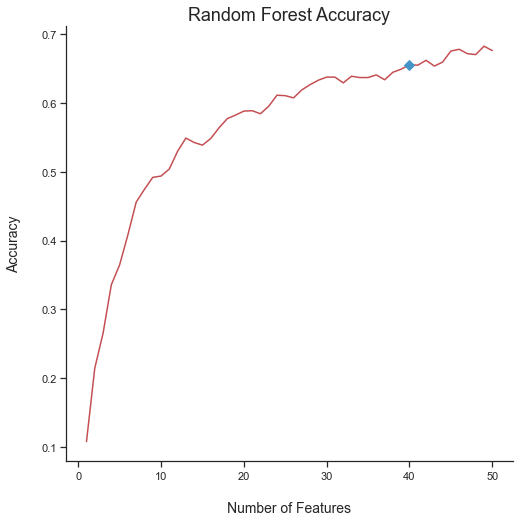

In [174]:
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.set_style("ticks")
plt.plot(numgenes, accuracy, '-rD', markevery=[10], markerfacecolor="#4594c7", markeredgecolor="#4594c7", markersize=7)
sns.despine()
plt.title('Random Forest Accuracy', fontsize=18)
plt.xlabel('Number of Features', fontsize=14,labelpad=20)
plt.ylabel('Accuracy', fontsize=14,labelpad=20)
#plt.savefig('Graphs/accuracy.pdf', format='pdf', transparent=True)
plt.show()